# TP bilan : inventaires de portefeuilles

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("FinalLabAPP") \
    .getOrCreate()

In [ ]:
from pyspark.sql import functions as F
from pathlib import Path
import matplotlib.pyplot as plt

Charger les 2 fichiers CSV inventaires dans des dataframes pandas. Explorer ces fichiers pour essayer d'en comprendre la structure.

In [ ]:
DATA_DIR = Path('../../data')
INPUT_DIR = Path(DATA_DIR, 'portfolio-inventories')
OUTPUT_DIR = Path(DATA_DIR, 'output')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

PORTFOLIO_CODE = 'Portoflio Code'
ASSET_CODE = 'Asset Code'
QUANTITY = 'Quantity'
VARIATION = 'Variation'
COLS = [PORTFOLIO_CODE, ASSET_CODE, QUANTITY]

In [8]:
df_day1 = (spark.read.option('header', True).option('sep', ';')
           .csv(str(INPUT_DIR / 'day1.ptf_inventories.csv'))
           .select(COLS))
df_day2 = (spark.read.option('header', True).option('sep', ';')
           .csv(str(INPUT_DIR / 'day2.ptf_inventories.csv'))
           .select(COLS))

Agréger les lignes multiples associées à un même couple (portfolio, asset), en utilisant une fonction d'agrégation pertinente.

In [9]:
agg_day1 = df_day1.groupBy(PORTFOLIO_CODE, ASSET_CODE).agg(F.sum(QUANTITY).alias(QUANTITY))
agg_day2 = df_day2.groupBy(PORTFOLIO_CODE, ASSET_CODE).agg(F.sum(QUANTITY).alias(QUANTITY))

Ecrire un petit script permettant de calculer les variations de chaque asset de chaque portfolio entre le jour 1 et le jour 2, dès lors qu'il y a eu une variation non nulle. Stocker les résultats dans un dataframe.

In [10]:
merged = (agg_day1.alias('d1')
          .join(agg_day2.alias('d2'),
                on=[PORTFOLIO_CODE, ASSET_CODE],
                how='full_outer')
          .select(
              F.coalesce(F.col(f'd1.{PORTFOLIO_CODE}'), F.col(f'd2.{PORTFOLIO_CODE}')).alias(PORTFOLIO_CODE),
              F.coalesce(F.col(f'd1.{ASSET_CODE}'), F.col(f'd2.{ASSET_CODE}')).alias(ASSET_CODE),
              F.coalesce(F.col(f'd1.{QUANTITY}'), F.lit(0)).alias('Quantity_before'),
              F.coalesce(F.col(f'd2.{QUANTITY}'), F.lit(0)).alias('Quantity_after')
          )
          .withColumn(VARIATION, F.col('Quantity_after') - F.col('Quantity_before')))
non_zero_variation = merged.filter(F.col(VARIATION) != 0)

Vous avez terminé la partie obligatoire ! <br>
Si vous avez terminé en avance, vous pouvez regarder la section suivante. <br>
Elle est relative à l'utilisation de matplotlib pour visualiser des données, et n'utilise plus Spark après une mini-manipulation initiale. Elle vise à illustrer le passage du BigData vers l'exploitation d'outils classiques lorsque la visualisation ne concerne qu'un échantillon de données.

Visualiser la composition du portefeuille 111111.

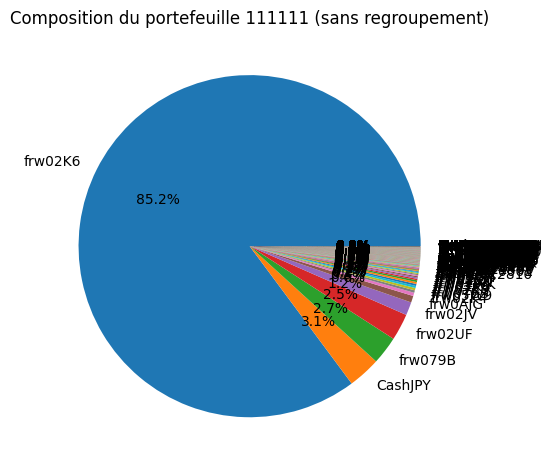

In [ ]:
portfolio_id = 111111

portfolio_df = agg_day1.filter(F.col(PORTFOLIO_CODE) == portfolio_id)

# Bring to pandas for plotting (small data):
pie_df = portfolio_df.orderBy(F.desc(QUANTITY)).toPandas()
pie_df = pie_df[pie_df[QUANTITY] > 0]

plt.figure()
plt.pie(pie_df[QUANTITY], labels=pie_df[ASSET_CODE], autopct='%1.1f%%')
plt.title(f'Composition du portefeuille {portfolio_id} (sans regroupement)')
plt.tight_layout()
plt.show()

Améliorer la visualisation en regroupant les assets représentant moins de 2% dans une catégorie "others".

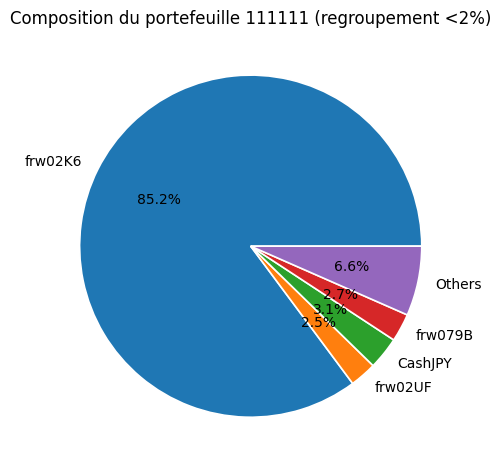

Graphique sauvegardé : ../../data/output/portfolio_111111.png


In [ ]:
# Compute total and threshold in Spark:
total_qty = portfolio_df.agg(F.sum(QUANTITY).alias('total')).first()['total']
threshold = 0.02 * total_qty

major_df = portfolio_df.filter(F.col(QUANTITY) >= threshold)
minor_df = portfolio_df.filter(F.col(QUANTITY) < threshold)

# Back to pandas:
major_pd  = major_df.toPandas()
labels = major_pd[ASSET_CODE].tolist()
values = major_pd[QUANTITY].tolist()

others_qty = minor_df.agg(F.sum(QUANTITY).alias('sum_minor')).first()['sum_minor']
if others_qty and others_qty > 0:
    labels.append('Others')
    values.append(others_qty)

plt.figure()
plt.pie(values, labels=labels, autopct='%1.1f%%', wedgeprops={'linewidth':1.2, 'edgecolor':'white'})
plt.title(f'Composition du portefeuille {portfolio_id} (regroupement <2%)')
plt.tight_layout()
img_path = OUTPUT_DIR / f'portfolio_{portfolio_id}.png'
plt.savefig(img_path, dpi=120)
plt.show()

print(f'Graphique sauvegardé : {img_path}')